In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('PRate.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
targetf = pd.read_csv('df_RotatedFactor_rel.csv')
targetf.index = pd.to_datetime(targetf['Date'])

In [4]:
targetf

,Date,RateFactor1
Date,,
2002-01-03,2002-01-03,-0.369641
2002-02-07,2002-02-07,-0.374494
2002-03-07,2002-03-07,0.049114
2002-04-04,2002-04-04,-0.015561
2002-05-02,2002-05-02,-0.267473
...,...,...
2018-03-08,2018-03-08,0.058954
2018-04-26,2018-04-26,0.084575
2018-06-14,2018-06-14,-0.089399


In [5]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
pcdf = pd.concat([pcdf, targetf], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)

dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdf = mpdf.loc[(mpdf.index<date1)].tail(1)
#tale always the last announcement
for i in range(0, len(dates_list)-1):
    newdfwork = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].tail(1)
    #print(newdfwork)
    newdf = newdf.append(newdfwork)
newdf.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpr = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpr = newdfpr.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1))
newdfpr.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpc = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpc = newdfpc.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].tail(1))
newdfpc.index = dates_list

#SUM DEFINITION
#mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
#mpdf.index = mpdf['date']
#prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
#prdf.index = prdf['date']
#pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
#pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfsum = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfworksum = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].sum()
    newdfsum = newdfsum.append(newdfwork, ignore_index = True)
newdfsum.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfprsum = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfprsum = newdfprsum.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].sum(), ignore_index = True)
newdfprsum.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpcsum = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpcsum = newdfpcsum.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].sum(),ignore_index = True)
newdfpcsum.index = dates_list

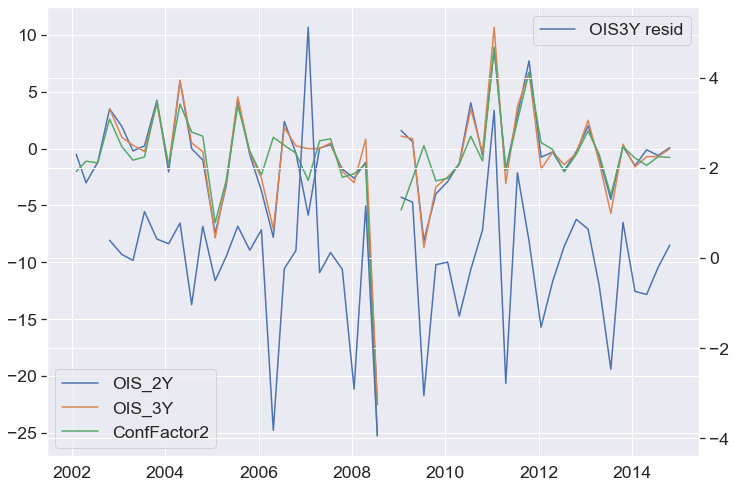

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
fig, ax1 = plt.subplots()
ax1.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')][['OIS_2Y', 'OIS_3Y', 'ConfFactor2']])
ax1.legend(['OIS_2Y', 'OIS_3Y', 'ConfFactor2'])
ax2 = ax1.twinx()
ax2.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')]['oisnew']);
ax2.legend(['OIS3Y resid']);

# transform data into means

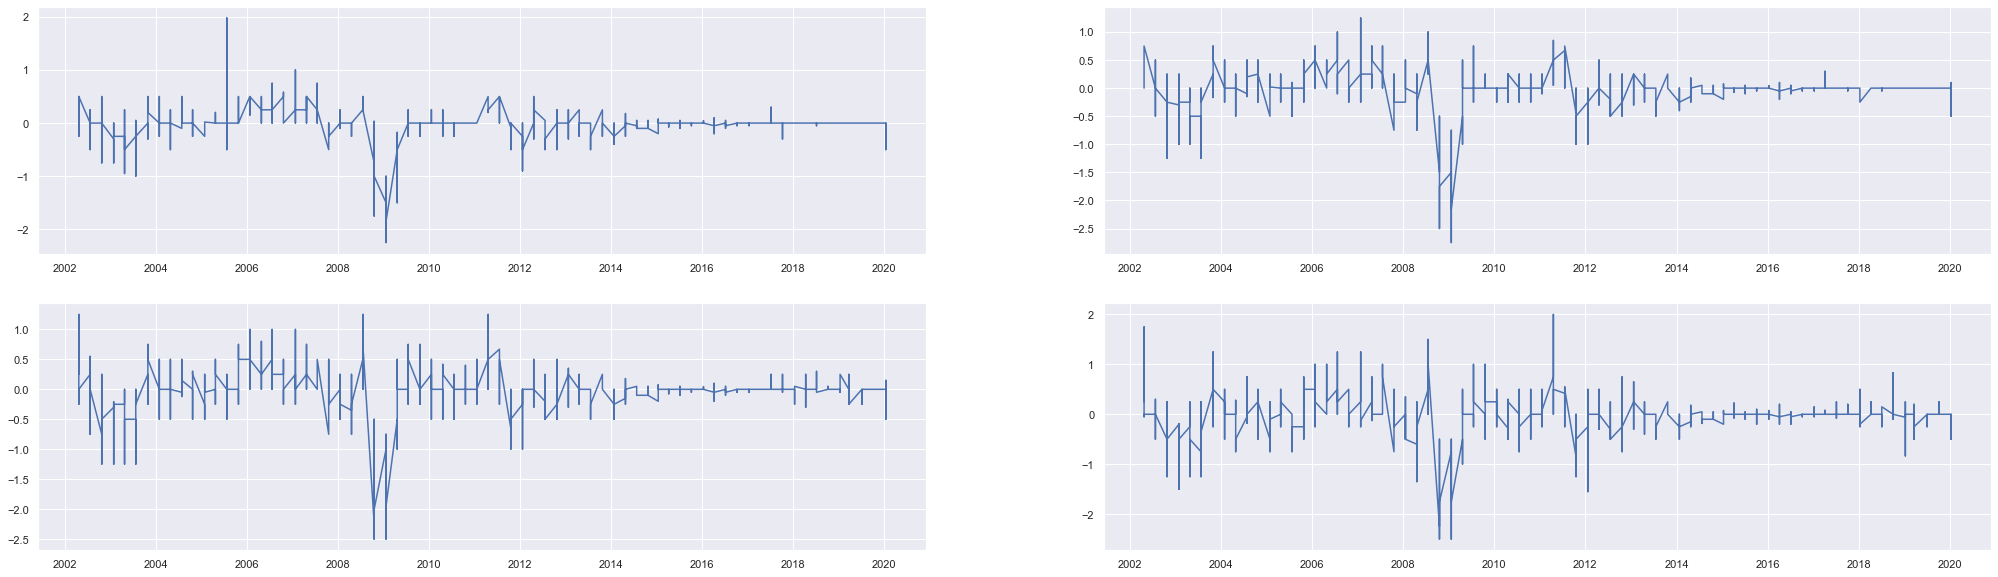

In [6]:
df_gdp['CurrentIR'] = df_gdp['CurrentIR'].astype(float)
df_gdp['IRQ1'] = df_gdp['IRQ1'].astype(float)
df_gdp['IRQ2'] = df_gdp['IRQ2'].astype(float)
df_gdp['IRQ3'] = df_gdp['IRQ3'].astype(float)

#df_gdp['IRQ4'] = df_gdp['IRQ4'].astype(float)
dfgdp1 = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
dfgdp1['diffCurrentIR'] = dfgdp1['CurrentIR'].diff()
dfgdp1['diffIRQ1'] = dfgdp1['IRQ1'].diff()
dfgdp1['diffIRQ2'] = dfgdp1['IRQ2'].diff()
dfgdp1['diffIRQ3'] = dfgdp1['IRQ3'].diff()
#dfgdp1['diffIRQ4'] = dfgdp1['IRQ4'].diff()
dfgdp1 = dfgdp1.sort_index()

fig, axs = plt.subplots(2, 2, figsize=(35, 10));
axs[0,0].plot(dfgdp1['diffCurrentIR'].dropna().astype(float))
axs[0,1].plot(dfgdp1['diffIRQ1'].dropna().astype(float))
axs[1,0].plot(dfgdp1['diffIRQ2'].dropna().astype(float))
axs[1,1].plot(dfgdp1['diffIRQ3'].dropna().astype(float));

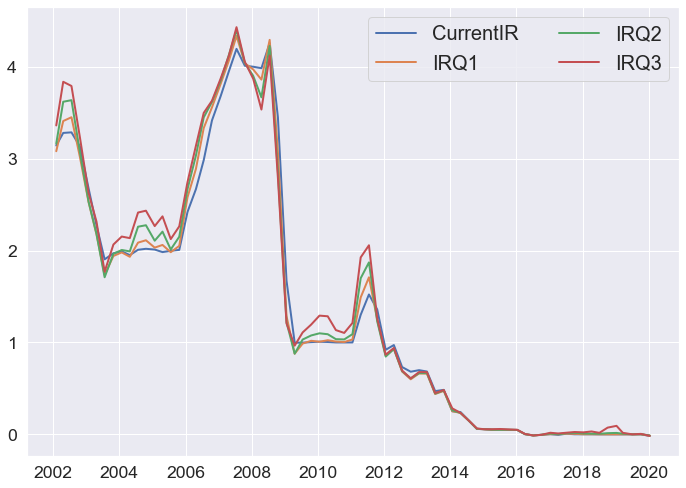

In [7]:
df1gdpmeans = dfgdp1.groupby('SurveyDate')[[ 'diffCurrentIR',
       'diffIRQ1', 'diffIRQ2', 'diffIRQ3']].mean()
df1gdpmeans1 = df_gdp.groupby('SurveyDate')[[ 'CurrentIR',
       'IRQ1', 'IRQ2', 'IRQ3']].mean()

sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans1, linewidth=2.0);
plt.legend(list(df1gdpmeans1), ncol=2, loc='upper right', fontsize=20);

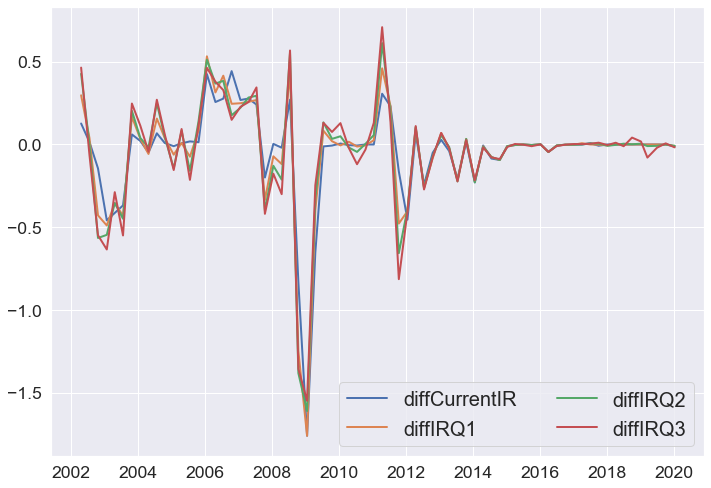

In [9]:
df1gdpmeansnew = dfgdp1.groupby('SurveyDate')[['CurrentIR',
       'IRQ1', 'IRQ2', 'IRQ3']].mean()
df1gdpmeansnew = df1gdpmeansnew.diff()
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans, linewidth=2.0);
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20);

In [10]:
df1gdpmeans1.tail(5)

,CurrentIR,IRQ1,IRQ2,IRQ3
SurveyDate,,,,
2019-01-11,0.000000,0.000000,0.015686,0.092630
2019-03-22,0.000000,0.000000,0.007143,0.016528
2019-07-05,0.000000,0.000000,0.000000,0.000000
2019-10-07,0.000000,0.000000,0.002128,0.005319
2020-01-13,-0.016393,-0.014754,-0.012295,-0.016393


In [8]:
df1gdpmeans1['IRQ1_lagged'] = df1gdpmeans1['IRQ1'].shift(1)#'CurrentIR'
df1gdpmeans1['Q1diff'] = df1gdpmeans1['CurrentIR'] - df1gdpmeans1['IRQ1_lagged']
df1gdpmeans1['IRQ3_lagged'] = df1gdpmeans1['IRQ3'].shift(1)#
df1gdpmeans1['Q3diff'] = df1gdpmeans1['IRQ2'] - df1gdpmeans1['IRQ3_lagged']
df1gdpmeans1['IRQ2_lagged'] = df1gdpmeans1['IRQ2'].shift(1)#
df1gdpmeans1['Q2diff'] = df1gdpmeans1['IRQ1'] - df1gdpmeans1['IRQ2_lagged']
#df1gdpmeans1['Q3diffT'] = df1gdpmeans1['IRQ3'].diff()


In [9]:
df1gdpmeans1[['CurrentIR', 'IRQ1']].loc[df1gdpmeans1.index>'2001-12-01']

,CurrentIR,IRQ1
SurveyDate,,
2002-02-04,3.142683,3.080488
2002-04-22,3.279348,3.408696
2002-07-22,3.285556,3.450000
2002-10-23,3.132308,3.018269
2003-01-27,2.675510,2.526122
...,...,...
2019-01-11,0.000000,0.000000
2019-03-22,0.000000,0.000000
2019-07-05,0.000000,0.000000


In [27]:
##get OLS estimate of the OIS 3Y
#order data

dataols = pd.concat([df1gdpmeans1, newdfpr], axis=1)
var = 'OIS_3M'
yvar = 'Q1diff'
#pp to basic points
dataols[yvar] = dataols[yvar]*100
dataols = dataols.dropna(subset = [var, yvar])
dataols['D1'] = (dataols[var]>0)*dataols[var]
dataols['D2'] = (dataols[var]<0)*dataols[var]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2014-01-01']
X = sm.add_constant(dataols[['D1', 'D2']])
model = sm.OLS(dataols[yvar], X)
results = model.fit(cov_type = 'HAC', cov_kwds={'maxlags': 4})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Q1diff   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     10.46
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           0.000169
Time:                        08:10:38   Log-Likelihood:                -228.83
No. Observations:                  51   AIC:                             463.7
Df Residuals:                      48   BIC:                             469.5
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7380      2.810      0.263      0.7

In [23]:
dataols['D1'][1]

-0.0

In [12]:
sd2

0.3367191793189289

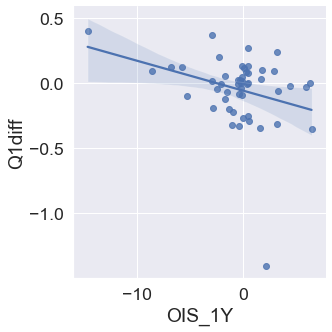

In [18]:
sns.lmplot(x = 'OIS_1Y', y = 'Q1diff', data = dataols)

# OIS residuals factors

In [104]:
dataols = pd.concat([df1gdpmeans1, newdfpc], axis=1)
var = 'ConfFactor1'
yvar = 'oisnew'
dataols = dataols.dropna(subset = [var, yvar]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
X = sm.add_constant(dataols[['ConfFactor1', 'ConfFactor2', 'ConfFactor3']])
model = sm.OLS(dataols[yvar], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 oisnew   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     7.578
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           0.000342
Time:                        08:59:34   Log-Likelihood:                -80.194
No. Observations:                  48   AIC:                             168.4
Df Residuals:                      44   BIC:                             175.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0139      0.201      0.069      